In [1]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

/home/thor/anaconda3/envs/paddle_torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [3]:
import os, cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as album
import shutil
import random


/home/thor/anaconda3/envs/paddle_torch/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:

# Paths for data directories
DATA_DIR = '/media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/segmentation/archive/leaf_disease_segmentation/orig_data'

print("Before Splitting the train and test")
print(len(os.listdir(os.path.join(DATA_DIR, 'train_images'))))
print(len(os.listdir(os.path.join(DATA_DIR, 'train_masks'))))

# List all files in train_images and train_masks directories
image_files = os.listdir(os.path.join(DATA_DIR, 'train_images'))
mask_files = os.listdir( os.path.join(DATA_DIR, 'train_masks'))
# Ensure each image has a corresponding mask
assert len(image_files) == len(mask_files)

# Sort the lists to ensure correspondence between images and masks
image_files.sort()
mask_files.sort()



# Directories for test data
test_images = os.path.join(DATA_DIR, 'test_images')
test_masks = os.path.join(DATA_DIR, 'test_masks')

valid_images = os.path.join(DATA_DIR, 'valid_images')
valid_masks = os.path.join(DATA_DIR, 'valid_masks')



Before Splitting the train and test
405
405


In [5]:
# Load the image
image = Image.open(test_masks + '/00029.png').convert('RGB')
# Convert the image to a NumPy array
image_array = np.array(image)
# Find unique colors in the image
unique_colors = np.unique(image_array.reshape(-1, image_array.shape[2]), axis=0)
# Convert unique colors to a list of tuples
unique_colors = [tuple(color) for color in unique_colors]
color = []

print("Unique RGB colors in the image:")
for idx, color in enumerate(unique_colors):
    print(f"Class {idx}: {color}")

# Get class names
class_names = ['background','affected']
# Get class RGB values
class_rgb_values = [[0, 0, 0], color] ## [0,0,0] for black background [color] for masked image

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = class_names
# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)
select_class_indices

Unique RGB colors in the image:
Class 0: (0, 0, 0)
Class 1: (128, 0, 0)
Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'affected']
Class RGB values:  [[0, 0, 0], (128, 0, 0)]


[0, 1]

In [6]:
train_images = os.path.join(DATA_DIR, 'train_images')
train_masks = os.path.join(DATA_DIR, 'train_masks')
print(len(os.listdir()))
print(len(os.listdir(os.path.join(DATA_DIR, 'train_masks'))))
print(len(os.listdir(test_images)))
print(len(os.listdir(test_masks)))
print(len(os.listdir(valid_images)))
print(len(os.listdir(valid_masks)))

6
405
93
93
90
90


In [ ]:
# helper function for data visualization
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()


# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map


# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


In [8]:
np.array(class_rgb_values)[[[1, 0 ,1]]]

array([[[128,   0,   0],
        [  0,   0,   0],
        [128,   0,   0]]])

In [ ]:
class PlantDiseaseDataset(torch.utils.data.Dataset):
    def __init__(
            self, images_dir, masks_dir, class_rgb_values=None, augmentation=None, preprocessing=None,
    ):
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        #Resize the image to 256 X 256
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask
    def __len__(self):
        return len(self.image_paths)

In [ ]:
dataset = PlantDiseaseDataset(train_images, train_masks, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(np.argmax(mask, axis = -1), select_class_rgb_values),
    one_hot_encoded_mask = np.argmax(mask, axis = -1)
)

In [11]:
def get_training_augmentation():
    train_transform = [
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),  # Add more augmentation
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        album.PadIfNeeded(
            min_height=256,
            min_width=256,
            always_apply=True,
            border_mode=0, # cv2.BORDER_CONSTANT
            value=0 # Black padding
        ),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

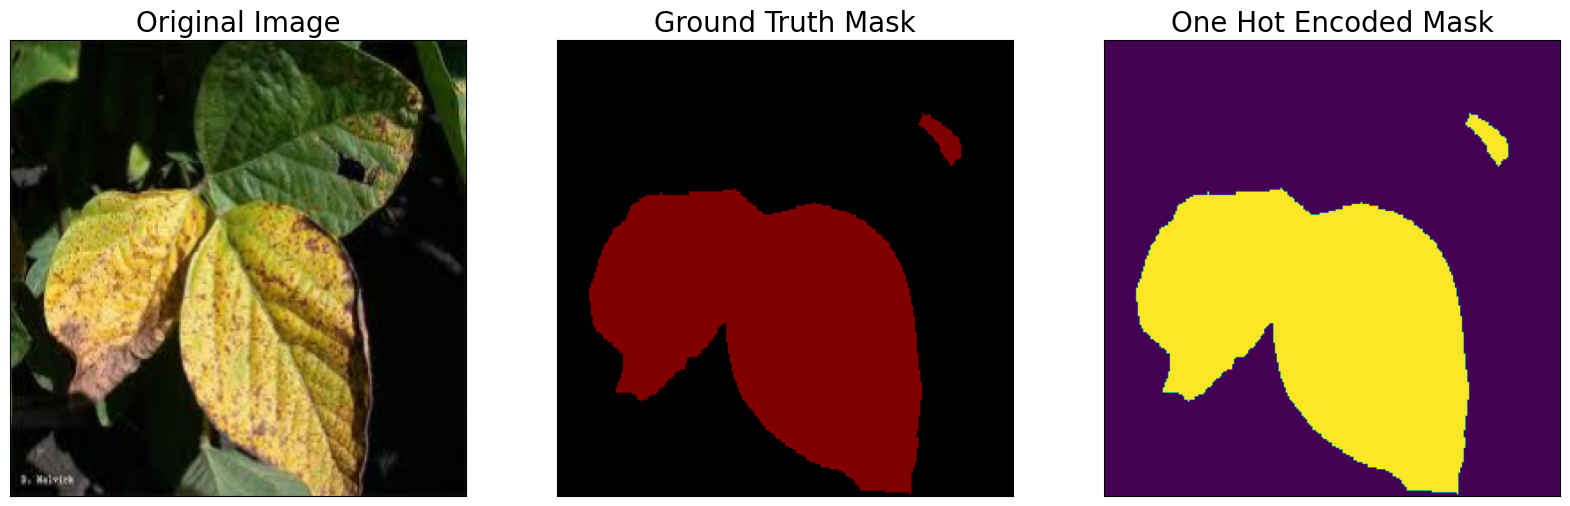

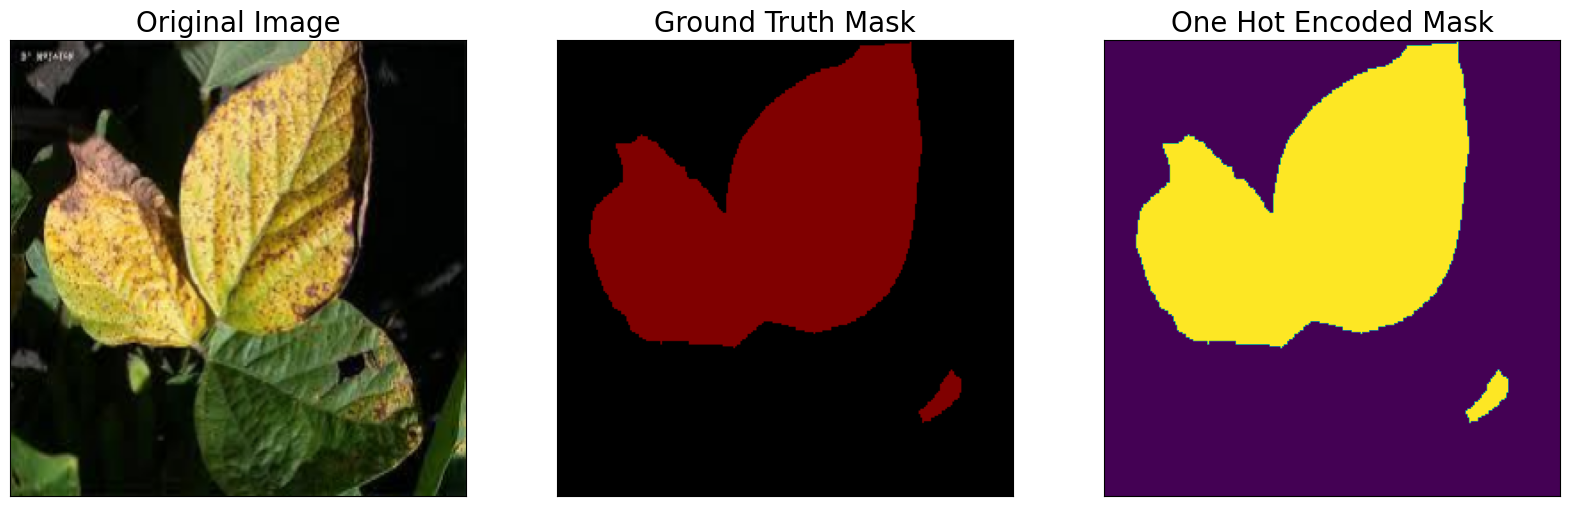

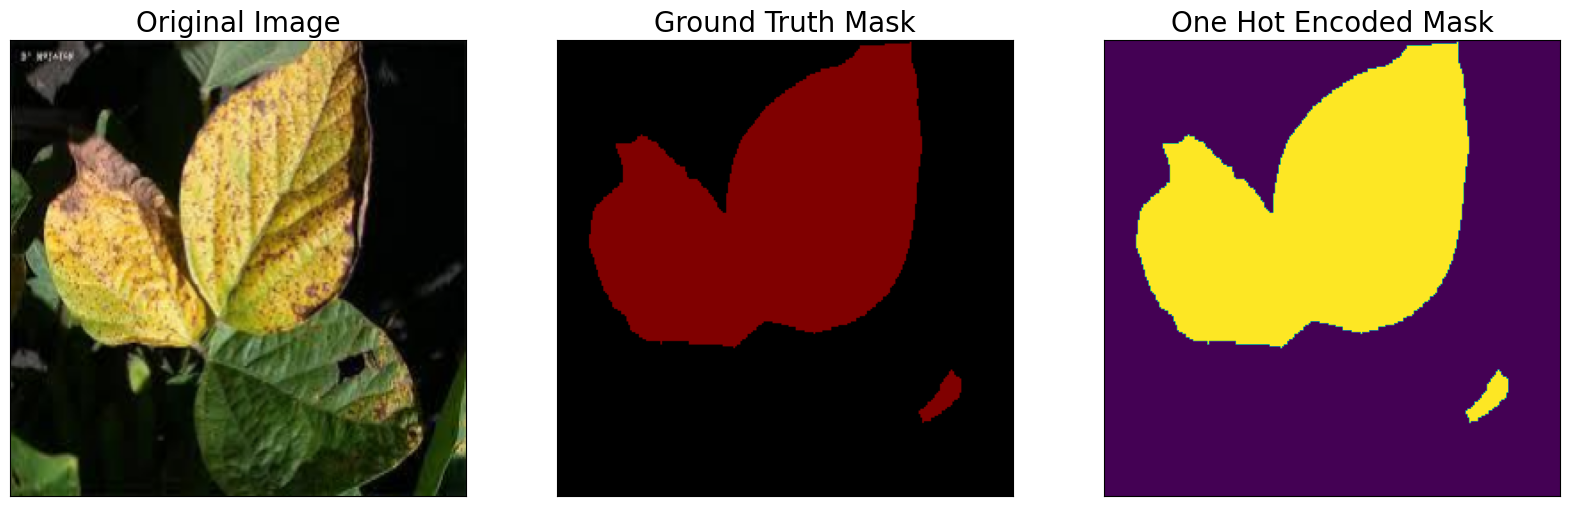

In [12]:
augmented_dataset = PlantDiseaseDataset(
    train_images, train_masks,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(np.argmax(mask, axis = -1), select_class_rgb_values),
        one_hot_encoded_mask = np.argmax(mask, axis = -1)
    )

In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
    activation='sigmoid',
)

In [15]:
from torchsummary import summary
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = (3,256, 256)  # 2 samples in the batch, 3 channels, 256x256 resolution

# Generate the model summary with a batch size of 8
summary(model.to(DEVICE), input_size=input_size, batch_size=20)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [20, 3, 257, 257]               0
Conv2dStaticSamePadding-2         [20, 64, 128, 128]           1,728
       BatchNorm2d-3         [20, 64, 128, 128]             128
MemoryEfficientSwish-4         [20, 64, 128, 128]               0
         ZeroPad2d-5         [20, 64, 130, 130]               0
Conv2dStaticSamePadding-6         [20, 64, 128, 128]             576
       BatchNorm2d-7         [20, 64, 128, 128]             128
MemoryEfficientSwish-8         [20, 64, 128, 128]               0
          Identity-9             [20, 64, 1, 1]               0
Conv2dStaticSamePadding-10             [20, 16, 1, 1]           1,040
MemoryEfficientSwish-11             [20, 16, 1, 1]               0
         Identity-12             [20, 16, 1, 1]               0
Conv2dStaticSamePadding-13             [20, 64, 1, 1]           1,088
         I

In [16]:
import segmentation_models_pytorch.utils

train_dataset = PlantDiseaseDataset(
    train_images, train_masks,
    augmentation = get_training_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn=None),
    class_rgb_values= select_class_rgb_values
)

valud_dataset = PlantDiseaseDataset(
    valid_images, valid_masks,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn=None),
    class_rgb_values = select_class_rgb_values
)

train_loader = DataLoader(train_dataset, batch_size = 24, shuffle= True, num_workers = 16)
valid_loader = DataLoader(valud_dataset, batch_size = 24, shuffle= False, num_workers = 4)

In [17]:
training = True
epochs = 200

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold = 0.5)
]

optimizer = torch.optim.Adam([
    dict( params = model.parameters(), lr = 0.0001)
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0 = 1, T_mult = 2, eta_min = 5e-5
)

In [18]:
m_path = '/media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/segmentation/model_save/'

if os.path.exists(os.path.join(m_path, 'best_model.pth')):
    torch.load(os.path.join(m_path, 'best_model.pth'), map_location=DEVICE)

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss = loss,
    metrics = metrics,
    optimizer = optimizer,
    device = DEVICE,
    verbose = True
)


valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
    verbose = True
)

In [19]:
if training:
    best_oiu_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, epochs):
        # Perform training & validation
        print('\nEpoch: {}'.format(i))

        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)

        

        if best_oiu_score < valid_logs['iou_score']:
            best_oiu_score = valid_logs['iou_score']
            torch.save(model, os.path.join(m_path, 'best_model.pth'))
            print('Model saved!')
        torch.save(model, os.path.join(m_path, 'last_model.pth'))

        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)



Epoch: 0
valid: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s, dice_loss - 0.9505, iou_score - 0.01712]
Model saved!

Epoch: 1
valid: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s, dice_loss - 0.7899, iou_score - 0.107] 
Model saved!

Epoch: 2
valid: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, dice_loss - 0.507, iou_score - 0.3996] 
Model saved!

Epoch: 3
valid: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, dice_loss - 0.3448, iou_score - 0.7028]
Model saved!

Epoch: 4
valid: 100%|██████████| 4/4 [00:01<00:00,  3.27it/s, dice_loss - 0.2952, iou_score - 0.7977]
Model saved!

Epoch: 5
valid: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s, dice_loss - 0.2736, iou_score - 0.8178]
Model saved!

Epoch: 6
valid: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s, dice_loss - 0.2468, iou_score - 0.8451]
Model saved!

Epoch: 7
valid: 100%|██████████| 4/4 [00:01<00:00,  3.49it/s, dice_loss - 0.2266, iou_score - 0.8592]
Model saved!

Epoch: 8
valid: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s, dice_los

KeyboardInterrupt: 

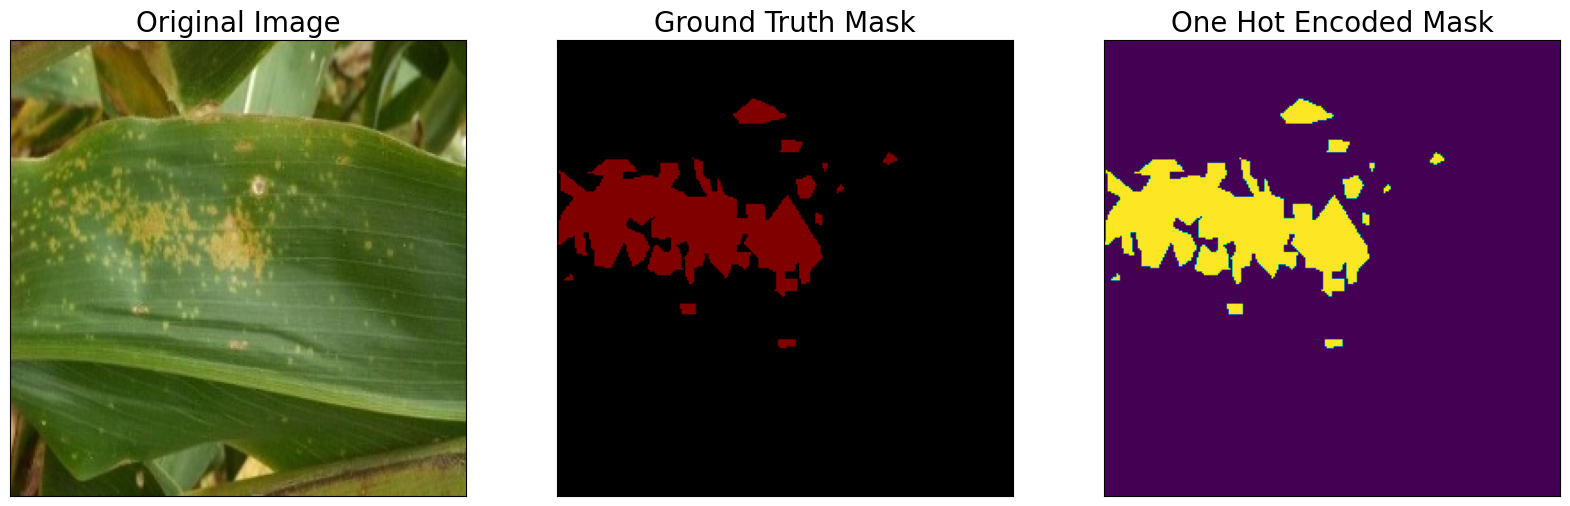

<module 'matplotlib.pyplot' from '/home/thor/anaconda3/envs/paddle_torch/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [71]:
best_model = torch.load(os.path.join(m_path, 'best_model.pth'), map_location=DEVICE)

test_dataset = PlantDiseaseDataset(
    test_images,test_masks,
    augmentation = get_validation_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn=None),
    class_rgb_values = select_class_rgb_values
)
test_dataloader = DataLoader(test_dataset)




test_dataset_vis = PlantDiseaseDataset( 
    test_images, test_masks,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize( original_image = image,
    ground_truth_mask = colour_code_segmentation( np.argmax(mask, axis = -1),  select_class_rgb_values), one_hot_encoded_mask = np.argmax(mask, axis = -1))


In [72]:
sample_preds_folder = 'sample_predictions/'

if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [73]:
test_dataset_vis[i][0].shape
test_dataset[random_idx][0].shape

(3, 256, 256)

In [74]:
select_classes.index('affected')

1

In [75]:
pred_building_heatmap.shape

(256, 256)

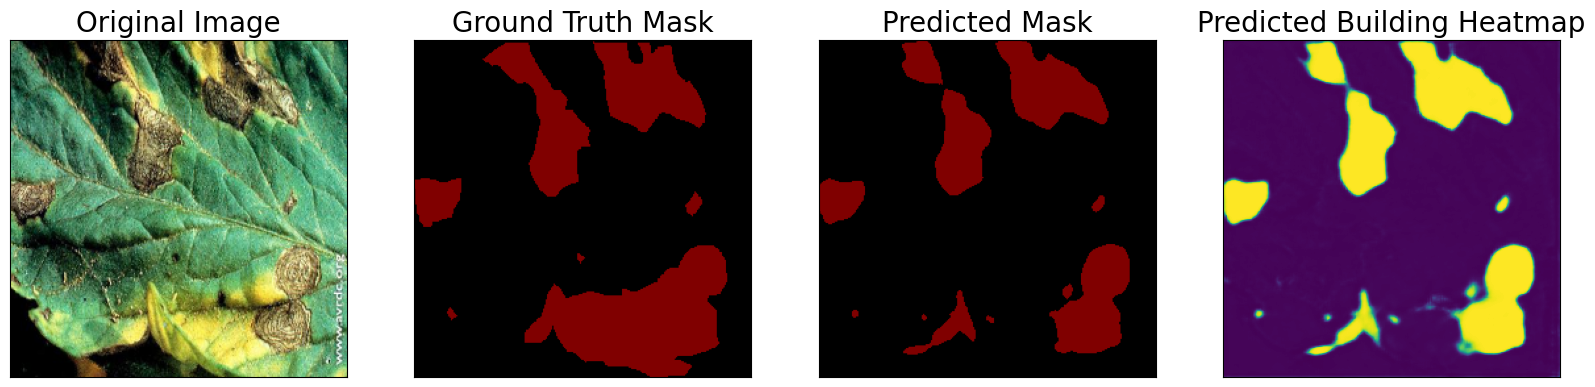

In [76]:
for idx in range(1):
    random_idx = random.randint(0, len(test_dataset)-1)

    image, gt_mask = test_dataset[random_idx]
    image_vis = np.transpose(image, (1,2,0)).astype('uint8')



    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    pred_mask = np.transpose(pred_mask, (1, 2, 0))


    pred_building_heatmap = pred_mask[:, :, 1]
    pred_mask = colour_code_segmentation(np.argmax(pred_mask, axis = -1), select_class_rgb_values)
    
 
    gt_mask = np.transpose(gt_mask, (1,2,0))
    gt_mask = colour_code_segmentation(np.argmax(gt_mask, axis = -1), select_class_rgb_values)



    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), 
                np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    pl = visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap  #For Heat Map
    )
 

In [77]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
    verbose = True
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on test data:")
print(f"Mean IoU score: {valid_logs['iou_score']: .4f}")
print(f"Mean IoU score: {valid_logs['dice_loss']: .4f}")

valid: 100%|██████████| 93/93 [00:03<00:00, 24.17it/s, dice_loss - 0.06635, iou_score - 0.9006]
Evaluation on test data:
Mean IoU score:  0.9006
Mean IoU score:  0.0663


In [78]:
import pandas as pd

train_df = pd.DataFrame(train_logs_list)
valid_df = pd.DataFrame(valid_logs_list)
# train_df

In [1]:
plt.figure(figsize=(8,5))
plt.plot(train_df.index, train_df['iou_score'], lw=1,label= 'Train')
plt.plot(valid_df.index, valid_df['iou_score'], lw=1, label= 'Valid')
plt.legend(loc='best', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('IOU score')
plt.grid()
plt.title('IoU Score Plot', fontsize=21)
plt.savefig('IOU_score.png')
plt.show()

NameError: name 'plt' is not defined

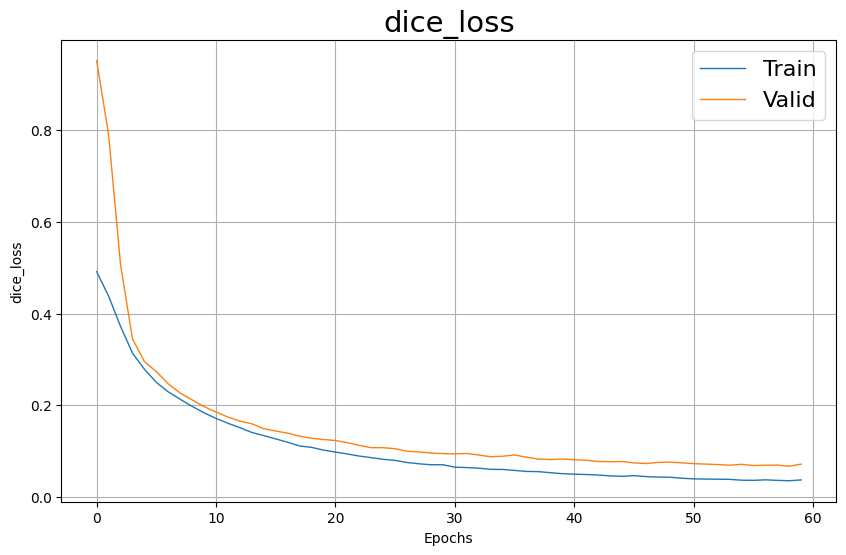

In [80]:
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['dice_loss'], lw=1,label= 'Train')
plt.plot(valid_df.index, valid_df['dice_loss'], lw=1, label= 'Valid')
plt.legend(loc='best', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('dice_loss')
plt.grid()
plt.title('dice_loss', fontsize=21)
plt.savefig('dice_loss.png')
plt.show()